In [1]:
import sys

sys.path

['/content',
 '/env/python',
 '/usr/lib/python38.zip',
 '/usr/lib/python3.8',
 '/usr/lib/python3.8/lib-dynload',
 '',
 '/usr/local/lib/python3.8/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.8/dist-packages/IPython/extensions',
 '/root/.ipython']

In [2]:
sys.path.append('/content/drive/MyDrive/Colab Notebooks/kgbuilder')

In [3]:
!pip install rdflib
!pip install datashader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500.3/500.3 KB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 KB 2.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 KB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for datashape: filename=datashape-0.5.2-py3-none-any.whl size=59439 sha256=e4ae73ea73fdd96f057b82767179c0f2ccbe32e8be56d8ad090b111623b1fe90
  Stored in directory: /root/.cache/pip/wheels/6d/79/c4/c425774559165f472d32e5ef592ff9a71179abb31f05dbc98b
Successfully built datashape


In [4]:
from rdflib import Graph
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph
import networkx as nx
import matplotlib.pyplot as plt

import requests

import pandas as pd

import datashader as ds
import datashader.transfer_functions as tf
from datashader.layout import random_layout, circular_layout, forceatlas2_layout
from datashader.bundling import connect_edges, hammer_bundle


from itertools import chain

import scipy

In [5]:
from utils import *

In [6]:
prune_policy={'remove_deadend':True, 'remove_isolated':True}

G=star_merging_pipeline(15, prune_policy)

[rdflib.term.URIRef('http://wikiba.se/ontology#BestRank'), rdflib.term.Literal('2015-04-03T00:00:00+00:00', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#dateTime')), rdflib.term.Literal('collection creator', lang='en'), rdflib.term.URIRef('http://wikiba.se/ontology#NormalRank'), rdflib.term.Literal('elFilm person ID', lang='en'), rdflib.term.URIRef('http://wikiba.se/ontology#Statement'), rdflib.term.URIRef('http://www.w3.org/2002/07/owl#Thing'), rdflib.term.Literal('en'), rdflib.term.Literal('MusicBrainz', lang='en'), rdflib.term.Literal('ca'), rdflib.term.URIRef('http://www.w3.org/2002/07/owl#Restriction'), rdflib.term.Literal('2019-04-08T00:00:00+00:00', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#dateTime')), rdflib.term.Literal('subreddit', lang='en'), rdflib.term.URIRef('http://wikiba.se/ontology#ExternalId'), rdflib.term.URIRef('http://wikiba.se/ontology#Property'), rdflib.term.URIRef('http://schema.org/Article'), rdflib.term.Literal('Soviet Uni

In [7]:
from visuals import *

In [9]:
image=create_plot_graph_force_directed(G)

In [10]:
type(image)

datashader.transfer_functions.Image

Force-directed

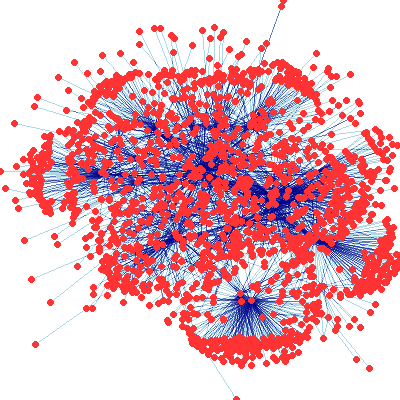

In [11]:
tf.Images(image).cols(1)